In [6]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image


In [2]:

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10
batch_size = 128
learning_rate = 0.001


In [3]:

# MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='data/', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)



In [36]:
class Reshape(nn.Module):
    def __init__(self, shape):
        super(Reshape, self).__init__()
        self.shape = shape
        # print(shape)

    def forward(self, x):
        return x.view(x.shape[0], *self.shape)
    

In [133]:
# Diffusion Model
class DiffusionModel(nn.Module):
    def __init__(self):
        super(DiffusionModel, self).__init__()
        self.encoder = nn.Sequential(
            
            Reshape((1,28, 28)),
            nn.Conv2d(
                in_channels=1,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=4,
                stride=2,
                padding=1,
            ),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),           
            
            nn.Flatten(),
            nn.Linear(49*64, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(100, 49*64),
            nn.ReLU(),
            Reshape((64,7,7)),

            nn.ConvTranspose2d(
                in_channels=64,
                out_channels=32,
                kernel_size=4,
                stride=2,
                padding=1,
                output_padding=0
            ),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),

            nn.ConvTranspose2d(
                in_channels=32,
                out_channels=1,
                kernel_size=4,
                stride=2,
                padding=1,
                output_padding=0
            ),
            nn.BatchNorm2d(num_features=1),
            nn.ReLU(),
            nn.Flatten()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        # print(encoded.shape)
        decoded = self.decoder(encoded)
        return decoded



In [134]:
# Initialize the model
model = DiffusionModel().to(device)
losses = []

Epoch [10/10], Step [400/469], Loss: 0.8454

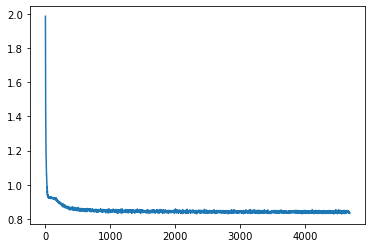

In [135]:
# Loss function
criterion = nn.MSELoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.reshape(-1, 784).to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, images)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'\rEpoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{total_step}], Loss: {loss.item():.4f}', end='')
        with torch.no_grad():
            losses.append(loss.item())
plt.plot(losses)


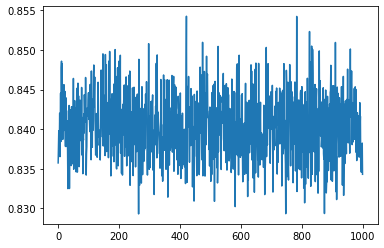

In [136]:
plt.plot(losses[-1000:])

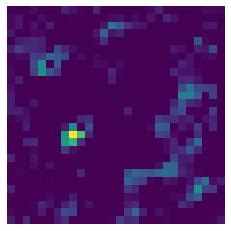

In [144]:
# Generate samples
with torch.no_grad():
    noise = torch.randn(16, 100).to(device)
    generated_images = model.decoder(noise).cpu().view((-1, 1, 28, 28))
    # print(generated_images.shape)

# Save generated images
save_image(generated_images, 'generated_images.png', nrow=4, normalize=True)
plt.imshow(generated_images[0, 0, :, :])
plt.axis('off')
plt.show()